## Pre-Process Data ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.datasets
import sklearn.metrics
from tqdm import tqdm
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from scipy.stats import gaussian_kde 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
class MultiClassRegression:
    
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.randn(nFeatures, nClasses) * 0.01  # Small random values
        
    def softmax(self, X):
        z = np.dot(X, self.W)
        z -= np.max(z, axis=1, keepdims=True)  # Improves numerical stability
        exp_scores = np.exp(z)
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probabilities
    
    def predict(self, X):
        return np.argmax(self.softmax(X), axis=1)
    
    def predict_top_k(self, X, k=3):
        """
        Predict the top k classes for each sample in X.
        """
        probabilities = self.softmax(X)
        top_k_predictions = np.argsort(probabilities, axis=1)[:, -k:]

        return top_k_predictions
    
    def loss_and_gradient(self, X, y):
        probabilities = self.softmax(X)
        N = X.shape[0]
        correct_logprobs = -np.log(probabilities[range(N), y])
        data_loss = np.sum(correct_logprobs) / N
        loss = data_loss
        
        dscores = probabilities
        dscores[range(N), y] -= 1
        dscores /= N
        dW = np.dot(X.T, dscores)
        
        return loss, dW
    
    def fit(self, X, y, lr=0.005, niters=100, validation_split=0):
        validation_split = int(X.shape[0] * validation_split)
        X_train, y_train = X[:-validation_split], y[:-validation_split]
        X_val, y_val = X[-validation_split:], y[-validation_split:]
        loss_history = []
        validation_loss = []

        # Create a tqdm object with a dynamic description
        pbar = tqdm(range(niters), desc='Initializing')
        best_weights = self.W

        for i in pbar:
            loss, dW = self.loss_and_gradient(X_train, y_train)
            self.W -= lr * dW

            if validation_split > 0:
                val_loss, val_dw = self.loss_and_gradient(X_val, y_val)
                validation_loss.append(val_loss)
            else:
                val_loss = 'N/A'  # No validation loss if validation_split is 0
                validation_loss.append(loss)
            
            if validation_loss[-1] != min(validation_loss):
                best_weights = self.W
            
            # if the min validation loss is more than 100 iterations ago, stop training
            if i > 10 and min(validation_loss) not in validation_loss[-100:]:
                print(f"Stopping early at iteration {i}, min validation loss: {min(validation_loss):.4f}")
                print(f"Best weights found at iteration {validation_loss.index(min(validation_loss))}")
                print("validation loss did not improve for 100 iterations")
                break
            
            loss_history.append(loss)
            # Update tqdm description
            if i % 10 == 0:
                pbar.set_description(f"Iter {i}, Loss: {float(loss):.4f}, Val Loss: {float(val_loss):.4f}")
        
        self.W = best_weights

        return self, loss_history, validation_loss
    
    
    def gradient_check(self, X, y, epsilon=1e-5):
        numerical_gradients = np.zeros_like(self.W)
        _, analytic_gradient = self.loss_and_gradient(X, y)
        
        it = np.nditer(self.W, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            old_value = self.W[ix]
            self.W[ix] = old_value + epsilon
            loss_plus_epsilon = self.loss_and_gradient(X, y)[0]
            self.W[ix] = old_value - epsilon
            loss_minus_epsilon = self.loss_and_gradient(X, y)[0]
            self.W[ix] = old_value
            
            numerical_gradients[ix] = (loss_plus_epsilon - loss_minus_epsilon) / (2 * epsilon)
            it.iternext()
   
        return np.abs(numerical_gradients - analytic_gradient) / (np.abs(numerical_gradients) + np.abs(analytic_gradient))

class CustomLogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=0.01, epsilon=1e-15, max_iters=1e5, verbose=False, lambda_reg=0.01, regularize=False, record_training=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        # Tolerance for the norm of gradients 
        self.max_iters = max_iters                    # Maximum number of iteration of gradient descent
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.regularize = regularize
        self.record_training = record_training
        self.loss_history = []
        self.val_loss_history = []
        self.gradient_norm_history = []
        
    def compute_loss(self, x, y):
        yh = self.logistic(np.dot(x, self.w))
        loss = -np.mean(y * np.log(yh+self.epsilon) + (1 - y) * np.log(1 - yh +self.epsilon))
        if self.regularize:
            loss += (self.lambda_reg / 2) * np.sum(self.w ** 2)
        return loss
    
    def gradient(self, x, y):
        N, D = x.shape
        yh = self.logistic(np.dot(x, self.w))  # predictions
        grad = np.dot(x.T, (yh - y)) / N
        if self.regularize:
            grad += (self.lambda_reg / N) * self.w  # L2 regularization, included conditionally
        return grad
    
    def logistic(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
        
    def fit(self, X, Y):
        val_split = 0.7
        val_num = int(val_split*len(X))
        # get random indices for the split
        indices = np.random.permutation(len(X))
        train_idx, val_idx = indices[:val_num], indices[val_num:]
        # split the data
        x, val_x = X[train_idx], X[val_idx]
        y, val_y = Y[train_idx], Y[val_idx]


        if self.verbose:
            print(f"Shape of x: {x.shape}")
            print(f"Shape of y: {y.shape}")
        if x.ndim == 1:
            x = x.reshape(-1, 1)
            val_x = val_x.reshape(-1, 1)
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
            N_v = val_x.shape[0]
            val_x = np.column_stack([val_x, np.ones(N_v)])

        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            if self.record_training:
                self.val_loss_history.append(self.compute_loss(val_x, val_y))
                self.loss_history.append(self.compute_loss(x, y))
                self.gradient_norm_history.append(np.linalg.norm(g))
            t += 1
        
        if self.verbose:
            print(f'Terminated after {t} iterations, with norm of the gradient = {np.linalg.norm(g)}')
            print(f'Weights: {self.w}')

    def predict(self, x):
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        yh = self.logistic(np.dot(x, self.w))
        return yh
    
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.w = None

    def fit(self, x, y):
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])  # Add bias term
        self.w = np.linalg.lstsq(x, y, rcond=None)[0]
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        return x @ self.w

### Extact, Transform, Load (ETL) ###

In [3]:

def load_vocab(vocab_file_path):
    """
    Loads the vocabulary from a file and creates two dictionaries: 
    one mapping indices to words and another mapping words to indices.
    """
    index_to_feature_map = {}
    with open(vocab_file_path, 'r', encoding='utf-8') as vocab_file:
        for index, word in enumerate(vocab_file):
            index_to_feature_map[str(index)] = word.strip()
    feature_to_index_map = {word: index for index, word in index_to_feature_map.items()}
    return index_to_feature_map, feature_to_index_map

def parse_review_features(line):
    features = line.strip().split()[1:]  # Skip the first element (label)
    return [feature.split(':') for feature in features]

def compute_review_frequencies(feature_path):
    """
    Computes the frequency of each word across reviews.
    """
    review_frequencies = defaultdict(int)
    total_reviews = 0
    with open(feature_path, 'r', encoding='utf-8') as feat_file:
        for line in feat_file:
            total_reviews += 1
            for index, _ in parse_review_features(line):
                review_frequencies[index] += 1
    return review_frequencies, total_reviews

def filter_feature_indices(review_frequencies, total_reviews, lower_bound=0.01, upper_bound=0.5):
    """
    Filters out feature indices based on review frequency criteria.
    """
    min_reviews = total_reviews * lower_bound
    max_reviews = total_reviews * upper_bound
    filtered_feature_indices = {index for index, freq in review_frequencies.items() 
                                if min_reviews <= freq <= max_reviews}

    return sorted([int(i) for i in filtered_feature_indices])

def load_review_features(feature_path, index_mapping, n_reviews, n_features):
    """
    Loads review features and labels into matrices based on a filtered and remapped vocabulary.
    """
    X = np.zeros((n_reviews, n_features))
    y = np.zeros(n_reviews)
    with open(feature_path, 'r') as file:
        for review_id, line in enumerate(file):
            parts = line.strip().split()
            y[review_id] = int(parts[0])  # First part is the label
            for index, count in parse_review_features(line):
                if index in index_mapping:
                    X[review_id, index_mapping[index]] = int(count)
    return X, y

def generate_frequency_table(vocab_file_path, feature_path):
    """
    Generates a frequency table of words in the dataset.
    
    Args:
    - vocab_file_path: Path to the vocabulary file.
    - feature_path: Path to the feature file containing word occurrences in reviews.
    
    Returns:
    - A sorted list of tuples, where each tuple contains (word, frequency).
    """
    index_to_word, word_to_index = load_vocab(vocab_file_path)
    review_frequencies, total_reviews = compute_review_frequencies(feature_path)
    word_frequencies = defaultdict(int)
    for index, freq in review_frequencies.items():
        word = index_to_word[index]
        word_frequencies[word] = freq
        
    sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)
    return sorted_word_frequencies


def filter_by_regression_coefficients(X, y, D=1000):
    model = LinearRegression()
    model.fit(X, y)
    coefficients = model.w[:-1]
    top_indices = np.argsort(np.abs(coefficients))[-D:]
    return top_indices, coefficients

def filter_by_logistic_regression_coefficients(X, y, D=1000):
    model = CustomLogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=1e2)
    model.fit(X, y)
    coefficients = model.w[:-1]
    top_indices = np.argsort(np.abs(coefficients))[-D:]
    return top_indices, coefficients

def extract_and_transform_multiclass_data(K=500, n_classes=5):
    """
    Get the news dataset and transform it into feature vectors.
    
    Args:
    - k: The number of features to select.
    - n_classes: The number of classes.
    
    Returns:
    - X_train_selected: The training feature vectors.
    - y_train: The training labels.
    - X_test_selected: The testing feature vectors.
    - y_test: The testing labels.
    """
    #Load the dataset
    if n_classes == 5:
        categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']
        
    elif n_classes == 10:
        categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 
                      'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 
                      'rec.sport.baseball']
        
    train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
    test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

    #Convert text to feature vectors
    count_vect = CountVectorizer(stop_words='english', max_df=0.5, min_df=2, ngram_range=(1, 1))
    X_train_counts = count_vect.fit_transform(train.data)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    #Feature selection using Mutual Information
    feature_selection = SelectKBest(mutual_info_classif, k=K)
    X_train_selected = feature_selection.fit_transform(X_train_tfidf, train.target)
    
    selected_indices = feature_selection.get_support(indices=True)
    selected_feature_names = np.array(count_vect.get_feature_names_out())[selected_indices]
    
    X_test_counts = count_vect.transform(test.data)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    X_test_selected = feature_selection.transform(X_test_tfidf)
    
    
    
    return X_train_selected, train.target, X_test_selected, test.target, selected_feature_names

# Evaluation and Plotting Functions #

### Evaluation Functions ###

In [4]:
def evaluate_multiclass_classification(X_train_selected, y_train, X_test_selected, y_test, n_classes=5):
    """
    Compute classification accuracy.
    
    Args:
    - X_train_selected: The training feature vectors.
    - y_train: The training labels.
    - X_test_selected: The testing feature vectors.
    - y_test: The testing labels.
    - n_classes: The number of classes.
    
    Returns:
    - accuracy: The classification accuracy.
    - y_pred: The predicted labels.
    """

    #Train the MultiClassRegression model
    n_features = X_train_selected.shape[1]
    mc_model = MultiClassRegression(nFeatures=n_features, nClasses=n_classes)
    _, loss_history, validation_loss = mc_model.fit(X_train_selected.toarray(), y_train, lr=0.05, niters=2000,validation_split=0.2)

    #Evaluate model
    y_pred = mc_model.predict(X_test_selected.toarray())
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

X_train_news, y_train_news, X_test_news, y_test_news, selected_feature_names = extract_and_transform_multiclass_data(K=500, n_classes=5)
#accuracy, y_ped = evaluate_multiclass_classification(X_train_news, y_train_news, X_test_news, y_test_news, n_classes=5)
#print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/usr/loc

### Plotting Functions ###

In [5]:

def plot_top_features(coefficients, sorted_indices, index_to_feature_map, reverse_index_mapping, title, n_features=10):
    """
    Plots the top N negative and positive features based on their coefficients, with a legend.
    
    Parameters:
    - coefficients: Array of feature coefficients from a regression model.
    - index_to_feature_map: Dictionary mapping original feature indices to words.
    - reverse_index_mapping: Dictionary mapping from reduced feature space to original index.
    - n_features: Number of top features to plot for both negative and positive coefficients.
    """
    
    # Separate positive and negative coefficients
    positive_indices = [i for i, coef in enumerate(coefficients) if coef > 0]
    negative_indices = [i for i, coef in enumerate(coefficients) if coef < 0]
    
    # Sort them by absolute values but keep the sign for color coding
    top_positive_indices = sorted(positive_indices, key=lambda i: coefficients[i], reverse=True)[:n_features]
    top_negative_indices = sorted(negative_indices, key=lambda i: coefficients[i])[:n_features]
    
    # Combine the indices and coefficients for plotting
    top_indices = top_negative_indices + top_positive_indices
    top_coefficients = [coefficients[i] for i in top_indices]
    top_words = [index_to_feature_map[str(reverse_index_mapping[i])] for i in top_indices]
    
    # Determine colors based on coefficient sign
    colors = ['red' if coef < 0 else 'blue' for coef in top_coefficients]
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x=np.abs(top_coefficients), y=top_words, palette=colors, orient='h')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.title(title)
    
    # Create a custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Positive'),
                       Patch(facecolor='red', edgecolor='red', label='Negative')]
    plt.legend(handles=legend_elements, title='Coefficient Sign')
    plt.savefig(f'experiment_1_results_{title}.png')
    plt.show()

def plot_training_progress(logistic_regression_model):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(logistic_regression_model.loss_history, label='Loss', color='b', ls='-',linewidth=1)
    plt.plot(logistic_regression_model.val_loss_history, label='Validation Loss', color='r', ls='-',linewidth=1)
    plt.title('Loss Progress over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(logistic_regression_model.gradient_norm_history, label='Gradient Norm')
    plt.title('Gradient Norm Progress over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.legend()
    plt.tight_layout()
    plt.savefig('experiment_2_training_progress_results.png')
    plt.show()
    
def plot_model_convergence(histories, results):
    """
    Display plots for model convergence: ROC curves, training losses, and gradient norms
    for different learning rates.
    
    Args:
    - histories: Dictionary mapping learning rates (str) to tuples of (loss_history, gradient_norm_history).
    - results: Dictionary mapping learning rates (str) to AUROC scores.
    """
    plt.figure(figsize=(18, 6))

    # Plot ROC curves
    plot_multiple_roc_curves(results, 'experiment_7_roc_results.png')

    # Plot training losses
    plt.subplot(1, 3, 2)
    for lr, (loss_history, _) in histories.items():
        plt.plot(loss_history, label=f'LR={lr}')
    plt.title('Training Loss Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gradient norms
    plt.subplot(1, 3, 3)
    for lr, (_, gradient_norm_history) in histories.items():
        plt.plot(gradient_norm_history, label=f'LR={lr}')
    plt.title('Gradient Norm Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.legend()

    plt.tight_layout()
    plt.savefig('experiment_7_training_results.png')
    plt.show()

def plot_binary_classification(results):
    """
    plot ROC curve
    compare to DT from sklearn
    
    Args:
    - results: tuple of fpr, tpr, auroc
    
    Return:
    - None, plot the ROC curve
    
    """
    fpr, tpr, auroc = results
    print(f"Area under the ROC curve: {auroc}")
    print(f"True positive rate: {tpr}")
    print(f"False positive rate: {fpr}")
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('experiment_4_results.png')
    plt.show()
    
def plot_multiple_roc_curves(results_dict,title):
    """
    Plot ROC curves for multiple classifiers.
    
    Args:
    - results_dict: Dictionary mapping model names (str) to tuples of (fpr, tpr, auroc).
    
    Return:
    - None, plot the ROC curves.
    """
    plt.figure(figsize=(10, 8))

    # Iterate through the results dictionary and plot each ROC curve
    for model_name, (fpr, tpr, auroc) in results_dict.items():
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC curve (area = {auroc:.2f})')
    
    # Plot diagonal line for no skill classifier
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(title)
    plt.show()
    

def plot_multiclass_classification(results):
    """
    compare accuracy to DT from sklearn
    
    """
    pass

def plot_top_20_features_from_imdb_simple(top_positive_features, top_negative_features):
    """
    A horizontal bar plot showing the top 20 features from the Simple linear regression on the IMDB data
    
    Characteristics:
    - 10 most positive and negative coefficients as the x-axis 
    - Feature names (i.e., words) as the y-axis  
    """
    # Plot the top 20 positive and negative features on the same plot
    plt.figure(figsize=(10, 10))
    # assign each a different color and make negatives positive
    top_negative_features['Impact'] = top_negative_features['Impact'].abs()
    plt.barh(top_positive_features['Word'].head(10), top_positive_features['Impact'].head(10), color='b', label='Positive Impact')
    plt.barh(top_negative_features['Word'].head(10), top_negative_features['Impact'].head(10), color='r', label='Negative Impact')
    plt.xlabel('Regression Coefficients (Absolute Value)')
    plt.ylabel('Word')
    plt.title('Top 20 Features from Simple Linear Regression')
    plt.legend()
    plt.savefig('top_20_features_from_imdb_simple.png')
    plt.show()


def plot_model_convergence(histories, results):
    """
    Display plots for model convergence: ROC curves, training losses, and gradient norms
    for different learning rates.
    
    Args:
    - histories: Dictionary mapping learning rates (str) to tuples of (loss_history, gradient_norm_history).
    - results: Dictionary mapping learning rates (str) to AUROC scores.
    """
    plt.figure(figsize=(18, 6))

    # Plot training losses
    plt.subplot(1, 2, 1)
    for lr, (loss_history, _) in histories.items():
        plt.plot(loss_history, label=f'LR={lr}')
    plt.title('Training Loss Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gradient norms
    plt.subplot(1, 2, 2)
    for lr, (_, gradient_norm_history) in histories.items():
        plt.plot(gradient_norm_history, label=f'LR={lr}')
    plt.title('Gradient Norm Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.legend()
    
    plt.savefig('experiment_6_results.png')
    plt.tight_layout()
    plt.show()
    
def plot_train_val_loss(train_loss, val_loss):
    """
    Plot the training and validation loss over iterations.
    
    Args:
    - train_loss: List of training loss values.
    - val_loss: List of validation loss values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss', color='b', linestyle='-', linewidth=1)
    plt.plot(val_loss, label='Validation Loss', color='r', linestyle='-', linewidth=1)
    plt.title('Training and Validation Loss Progress')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('experiment_6_loss_results.png')
    plt.show()

def plot_imdb_data_auroc(results):
    """
    A bar plot that shows the AUROC of logistic regression and DT on the test data (y-axis) 
    as a function of the 20%, 40%, 60%, 80%, and 100% training data (x-axis).
    """
    # Extracting percentages and scores
    percentages = list(results.keys())
    accuracy_mc = [result[0] for result in results.values()]
    accuracy_dt = [result[1] for result in results.values()]
    
    # Setting up the bar plot with an adjusted figure size
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    ax = plt.subplot(111)
    index = np.arange(len(results))
    bar_width = 0.35
    opacity = 0.8
    
    bars1 = ax.bar(index, accuracy_mc, bar_width, alpha=opacity, color='b', label='Logistic Regression')
    bars2 = ax.bar(index + bar_width, accuracy_dt, bar_width, alpha=opacity, color='g', label='Decision Tree')
    
    # Adding labels, title, and axes ticks
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel('AUROC')
    ax.set_title('AUROC by Model and Training Set Size')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentages)
    
    # Adjusting the legend position to avoid overlap and ensure it's inside the plot area
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    
    # Add labels onto the bars with some adjustments for better readability
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    # Adjust layout to make room for the legend and ensure labels are not cut off
    plt.subplots_adjust(right=0.75)
    plt.tight_layout()
    plt.savefig('experiment_5_results.png')
    plt.show()
    
def plot_word_distribution(review_frequencies, title):
    """
    Plots a histogram and distribution of word counts in a dataset.
    Args:
    - data: Tuple containing (review_frequencies, total_reviews), where review_frequencies
      is a dictionary mapping word indices to frequencies, and total_reviews is the total number of reviews.
    - title: Title for the plot.
    """
    indices = np.array([int(index) for index in review_frequencies.keys()])
    frequencies = np.array(list(review_frequencies.values()))
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(indices, weights=frequencies, bins=100, color='skyblue', edgecolor='black')
    plt.title(f'{title} - Histogram')
    plt.xlabel('Word Index')
    plt.ylabel('Frequency')
    plt.yscale('log', nonpositive='clip')
    plt.grid(True, which="both", ls="--")
    
    plt.subplot(1, 2, 2)
    kde = gaussian_kde(indices, weights=frequencies)
    idx_range = np.linspace(indices.min(), indices.max(), 300)
    plt.plot(idx_range, kde(idx_range), color='darkblue', lw=2)
    plt.title(f'{title} - Density Plot')
    plt.xlabel('Word Index')
    plt.ylabel('Density')
    plt.yscale('log', nonpositive='clip')

    plt.tight_layout()
    plt.savefig(f'imdb_dataset_word_distribution.png')
    plt.show()
    

def plot_news_data_classification_accuracy(results):
    """
    Plot the classification accuracies of mutliclass regression, DT, and KNN on the test data.
    
    Args:
    - results: Dictionary mapping model names (str) to classification accuracies.
    """
    # Extracting model names and scores
    model_names = list(results.keys())
    accuracies = list(results.values())
    
    # Setting up the bar plot with an adjusted figure size
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    ax = plt.subplot(111)
    index = np.arange(len(results))
    bar_width = 0.35
    opacity = 0.8
    
    bars = ax.bar(index, accuracies, bar_width, alpha=opacity, color='b')
    
    # Adding labels, title, and axes ticks
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Classification Accuracy by Model')
    ax.set_xticks(index)
    ax.set_xticklabels(model_names)
    
    # Add labels onto the bars with some adjustments for better readability
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    # Adjust layout to ensure labels are not cut off
    plt.tight_layout()
    plt.savefig('experiment_2_newsdata_results.png')
    plt.show()
    
def plot_news_data_on_multiple_training_sizes(results):
    """
    A bar plot that shows the classification accuracies of multiclass regression and DT 
    on the test data (y-axis) as a function of the 20%, 40%, 60%, 80%, and 100% training data (x- axis)
    """
    
    # Extracting percentages and scores
    percentages = list(results.keys())
    accuracy_mc = [result[0] for result in results.values()]  # Multiclass regression accuracies
    accuracy_dt = [result[1] for result in results.values()]  # Decision tree accuracies
    
    # Setting up the bar plot with an adjusted figure size
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    ax = plt.subplot(111)
    index = np.arange(len(results))
    bar_width = 0.35
    opacity = 0.8
    
    bars1 = ax.bar(index, accuracy_mc, bar_width, alpha=opacity, color='b', label='MC Regression')
    bars2 = ax.bar(index + bar_width, accuracy_dt, bar_width, alpha=opacity, color='g', label='Decision Tree')
    
    # Adding labels, title, and axes ticks
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Model and Training Set Size')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(percentages)
    
    # Adjusting the legend position to avoid overlap and ensure it's inside the plot area
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    # Adjust layout to make room for the legend and ensure labels are not cut off
    plt.subplots_adjust(right=0.75)
    plt.tight_layout()
    plt.savefig('experiment_4_results.png')
    plt.show()
    
def plot_heatmap_of_multi_classification(weights, feature_names, class_label_dict, n_top_features=5):
    """
    Plot a heatmap showing the top 5 most positive features as rows for each class as columns,
    with class labels replaced by their actual text labels.
    
    Args:
    - weights: The weights matrix from the multi-class regression model.
    - feature_names: The names of the features.
    - class_label_dict: A dictionary mapping numerical class labels to text labels.
    - n_top_features: The number of top features to consider for each class.
    """
    n_classes = 5
    top_features_idx = np.argsort(weights, axis=0)[-n_top_features:]  # Top 5 features for each class
    
    # Initialize a matrix to hold the adjusted weights
    adjusted_weights = np.zeros((n_top_features * n_classes, n_classes))
    
    # Dictionary to track the mapping of features to rows in the adjusted matrix
    feature_to_row = {}
    current_row = 0
    
    for class_idx in range(n_classes):
        for feature_pos in range(n_top_features):
            feature_idx = top_features_idx[feature_pos, class_idx]
            feature_name = feature_names[feature_idx]
            
            # Assign this feature to a new row if not already mapped
            if feature_name not in feature_to_row:
                feature_to_row[feature_name] = current_row
                current_row += 1
            
            row_idx = feature_to_row[feature_name]
            adjusted_weights[row_idx, class_idx] = weights[feature_idx, class_idx]
    
    # Create a list of feature names sorted by their row assignment
    sorted_feature_names = [None] * len(feature_to_row)
    for feature_name, row_idx in feature_to_row.items():
        sorted_feature_names[row_idx] = feature_name
    
    # Replace numerical class labels with text labels for plotting
    class_text_labels = [class_label_dict[i+1] for i in range(n_classes)]  # Adjust index if necessary
    
    # Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(adjusted_weights, annot=True, cmap='viridis', fmt=".2f",
                xticklabels=class_text_labels,
                yticklabels=sorted_feature_names)
    plt.title('Top 5 Features for Each Class (Adjusted)')
    plt.savefig('experiment_9_heatmap_results.png')
    plt.xlabel('Class')
    plt.ylabel('Feature')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Experiments #

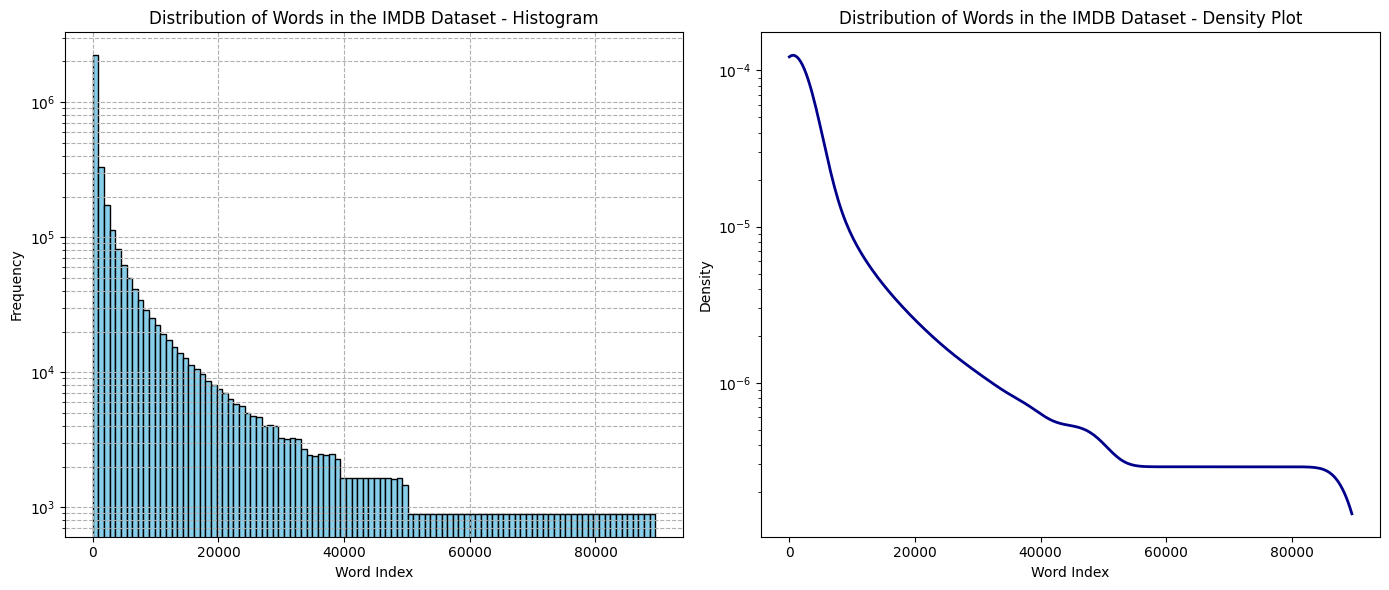

In [6]:

# Driver code to load everything

# Define globals
VOCAB_FILE = '../aclImdb/imdb.vocab'
TRAIN_FEAT = '../aclImdb/train/labeledBow.feat'
TEST_FEAT = '../aclImdb/test/labeledBow.feat'
N_REVIEWS = 25000

# load the data and filter the reviews
index_to_feature_map, feature_to_index_map = load_vocab(VOCAB_FILE)
review_frequencies, total_reviews = compute_review_frequencies(TRAIN_FEAT)
filtered_indices = filter_feature_indices(review_frequencies, total_reviews)
index_mapping = {str(old_index): new_index for new_index, old_index in enumerate(filtered_indices)}

# plot the distribution
plot_word_distribution(review_frequencies, "Distribution of Words in the IMDB Dataset")

# create train and test based on the filtered indices
N_FEATURES = len(filtered_indices)
X_train, y_train = load_review_features(TRAIN_FEAT, index_mapping, N_REVIEWS, N_FEATURES)
X_test, y_test = load_review_features(TEST_FEAT, index_mapping, N_REVIEWS, N_FEATURES)

# Now filter by the regression coefficients
top_indices, coefficients = filter_by_regression_coefficients(X_train, y_train)
reverse_index_mapping = {new_index: old_index for old_index, new_index in index_mapping.items()}

# Convert y_train and y_test to binary
y_train_binary = (y_train > 5).astype(int)
y_test_binary = (y_test > 5).astype(int)

# Filter by regression coefficients from logistic regression
top_log_indices, top_log_coefficients = filter_by_logistic_regression_coefficients(X_train, y_train_binary)
reverse_index_mapping = {new_index: old_index for old_index, new_index in index_mapping.items()}

# Filter features based on top_indices
X_train_filtered = X_train[:, top_indices]
X_test_filtered = X_test[:, top_indices]

### Experiment 1 ###

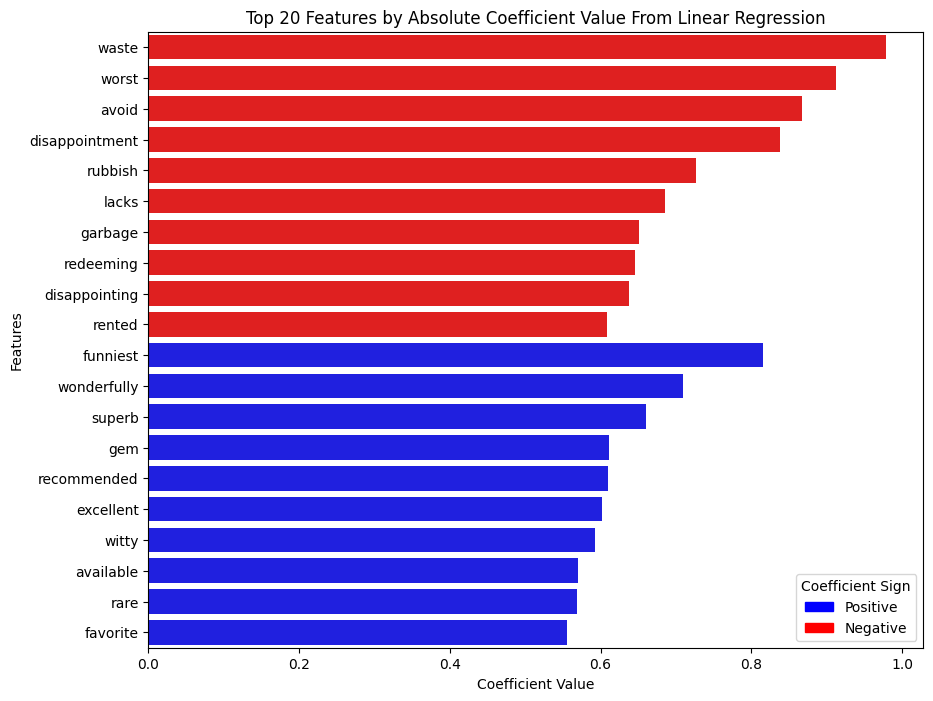

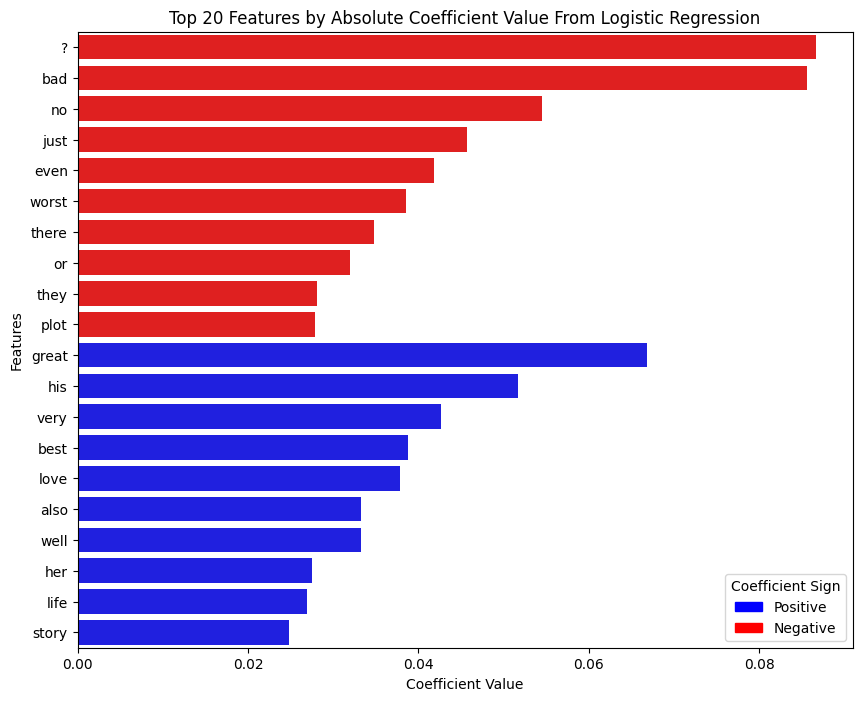

In [7]:
def experiment_one():
    """
    Report the:
    - top 10 features with the most positive coefficients
    - top 10 features with the most negative coefficients 
    
    on the IMDB data using simple linear regression on the movie rating scores
    """
    title1 = 'Top 20 Features by Absolute Coefficient Value From Linear Regression'
    title2 = 'Top 20 Features by Absolute Coefficient Value From Logistic Regression'
    plot_top_features(coefficients, top_indices[::-1], index_to_feature_map, reverse_index_mapping, title1, n_features=10)
    plot_top_features(top_log_coefficients, top_log_indices[::-1], index_to_feature_map, reverse_index_mapping, title2, n_features=10)
    

experiment_one()

### Experiment 2 ###

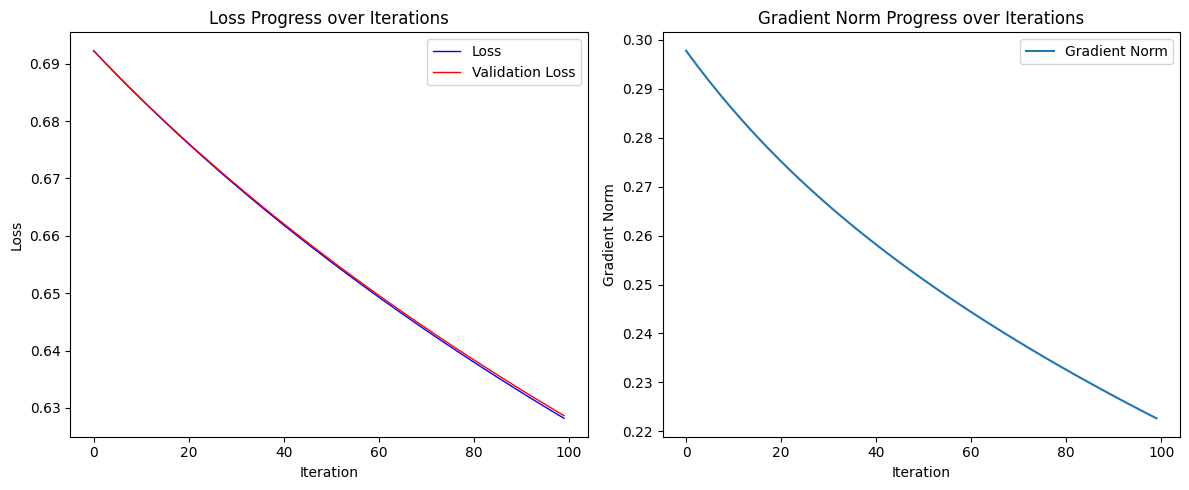

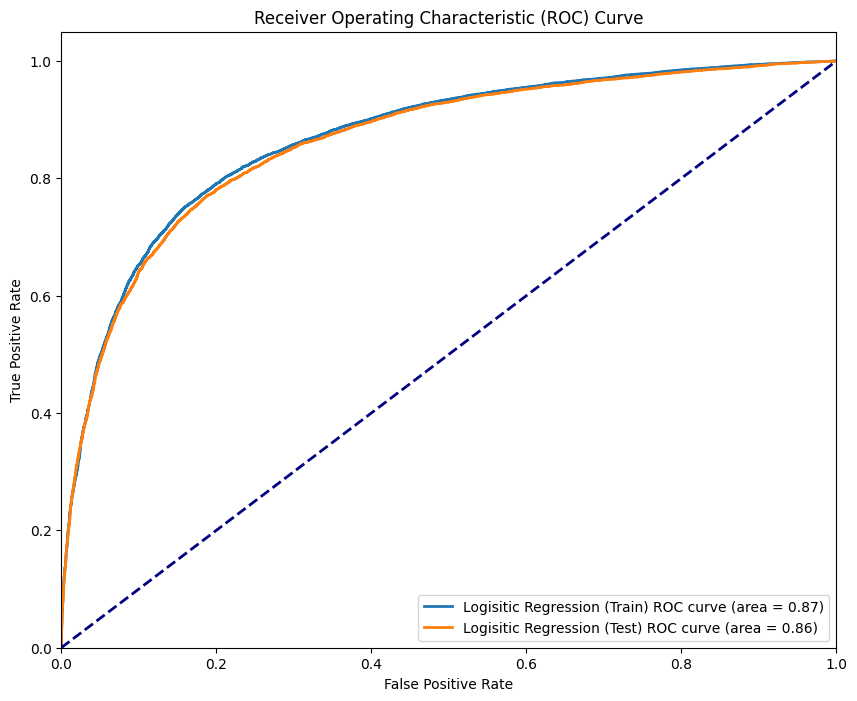

In [8]:
def experiment_two(X_train, y_train, X_test, y_test, top_indices):
    """
    Implement and conduct Binary classification on the IMDb Reviews
    """
    
    model = CustomLogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=1e2,record_training=True)
    model.fit(X_train_filtered, y_train_binary)
    plot_training_progress(model)
    y_pred_prob_test = model.predict(X_test_filtered)
    y_pred_prob_train = model.predict(X_train_filtered)
    
    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test_binary, y_pred_prob_test)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_pred_prob_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    results = {"Logisitic Regression (Train)": (fpr_train, tpr_train, roc_auc_train), 
               "Logisitic Regression (Test)": (fpr_test, tpr_test, roc_auc_test)}
    plot_multiple_roc_curves(results, 'experiment_2_results.png')
    
experiment_two(X_train_filtered, y_train_binary, X_test_filtered, y_test_binary, top_indices)

Iter 1990, Loss: 1.4904, Val Loss: 1.4955: 100%|██████████| 2000/2000 [00:06<00:00, 320.96it/s]


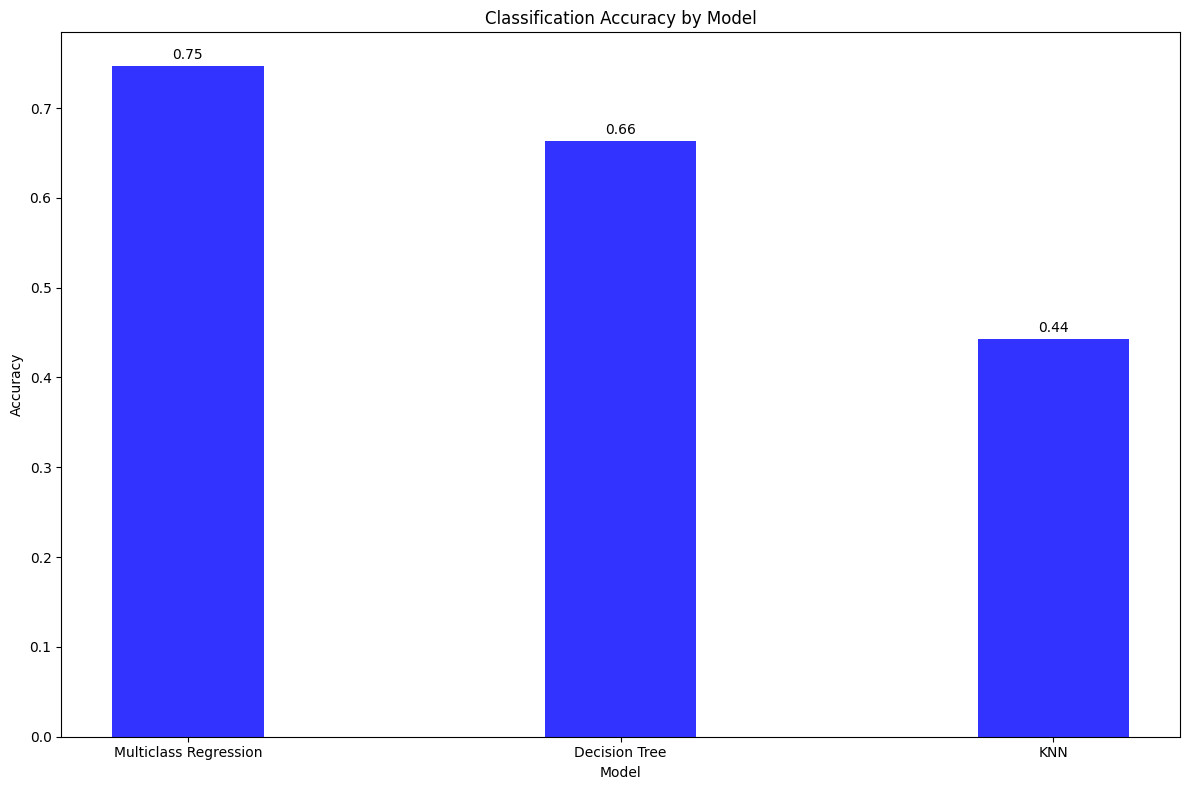

In [9]:
def experiment_two_multiclass(X_train_selected, y_train, X_test_selected, y_test, n_classes=5):
    """
    Plot the multiclass classification accuracy of multiclass linear regression and Decision Trees 
    on the 5 chosen classes from the 20-news-group data
    """
    multiclass_accuracy, y_pred = evaluate_multiclass_classification(X_train_selected, y_train, X_test_selected, y_test, n_classes)
    
    # Train a Decision Tree model
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train_selected, y_train) 
    y_pred_dt = dt_model.predict(X_test_selected)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    
    # Train a KNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_selected, y_train)
    y_pred_knn = knn_model.predict(X_test_selected)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    
    # Plot the results
    results = {"Multiclass Regression": multiclass_accuracy, "Decision Tree": accuracy_dt, "KNN": accuracy_knn}
    plot_news_data_classification_accuracy(results)
    
experiment_two_multiclass(X_train_news, y_train_news, X_test_news, y_test_news, n_classes=5)

### Experiment 3 ###

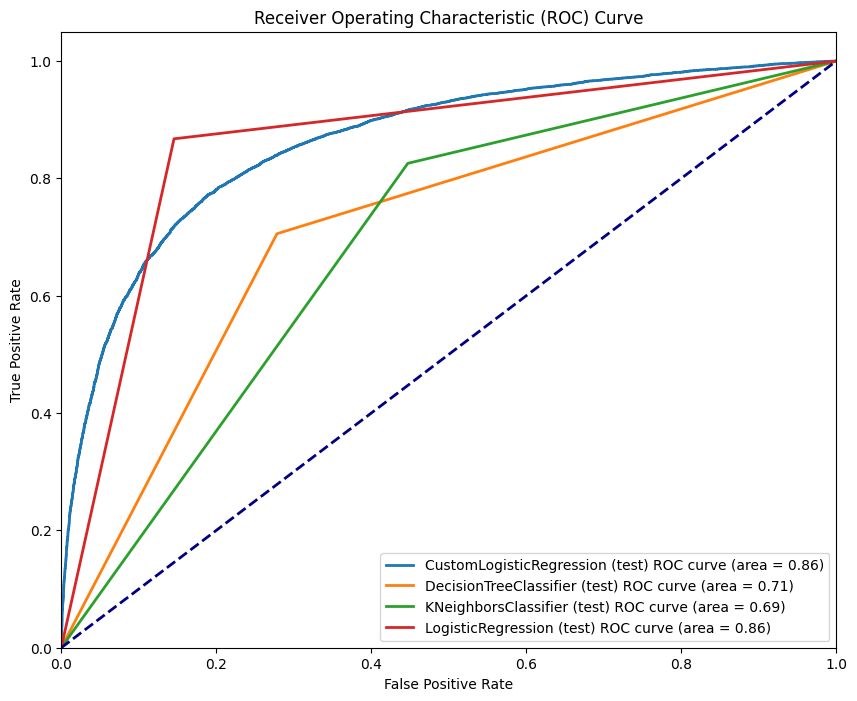

In [10]:
def experiment_three(X_train, y_train, X_test, y_test, top_indices):
    """
    On the same plot as 2, draw ROC curves and report the AUROC 
    values of logistic regression and Decision Trees on the 
    IMDB data binary classification task
    """
    
    models = [CustomLogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=1e2), 
              DecisionTreeClassifier(), 
              KNeighborsClassifier(), 
              LR(C=1/0.01, fit_intercept=True, max_iter=int(1e2), tol=1e-5)] #sklearn logistic regression
    results = {}
    for model in models:
        model.fit(X_train, y_train)
        y_pred_prob_test = model.predict(X_test)
        y_pred_prob_train = model.predict(X_train)

        # Compute ROC curve and ROC area for the test set
        fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
        roc_auc_test = auc(fpr_test, tpr_test)

        # Compute ROC curve and ROC area for the training set
        fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
        roc_auc_train = auc(fpr_train, tpr_train)

        #results[f'{model.__class__.__name__} (train)'] = (fpr_train, tpr_train, roc_auc_train)
        results[f'{model.__class__.__name__} (test)'] = (fpr_test, tpr_test, roc_auc_test)
        
    plot_multiple_roc_curves(results,title='experiment_3_results.png')
    
experiment_three(X_train_filtered, y_train_binary, X_test_filtered, y_test_binary, top_indices)

### Experiment 4 ###

Iter 1990, Loss: 1.4903, Val Loss: 1.4955: 100%|██████████| 2000/2000 [00:08<00:00, 243.43it/s]


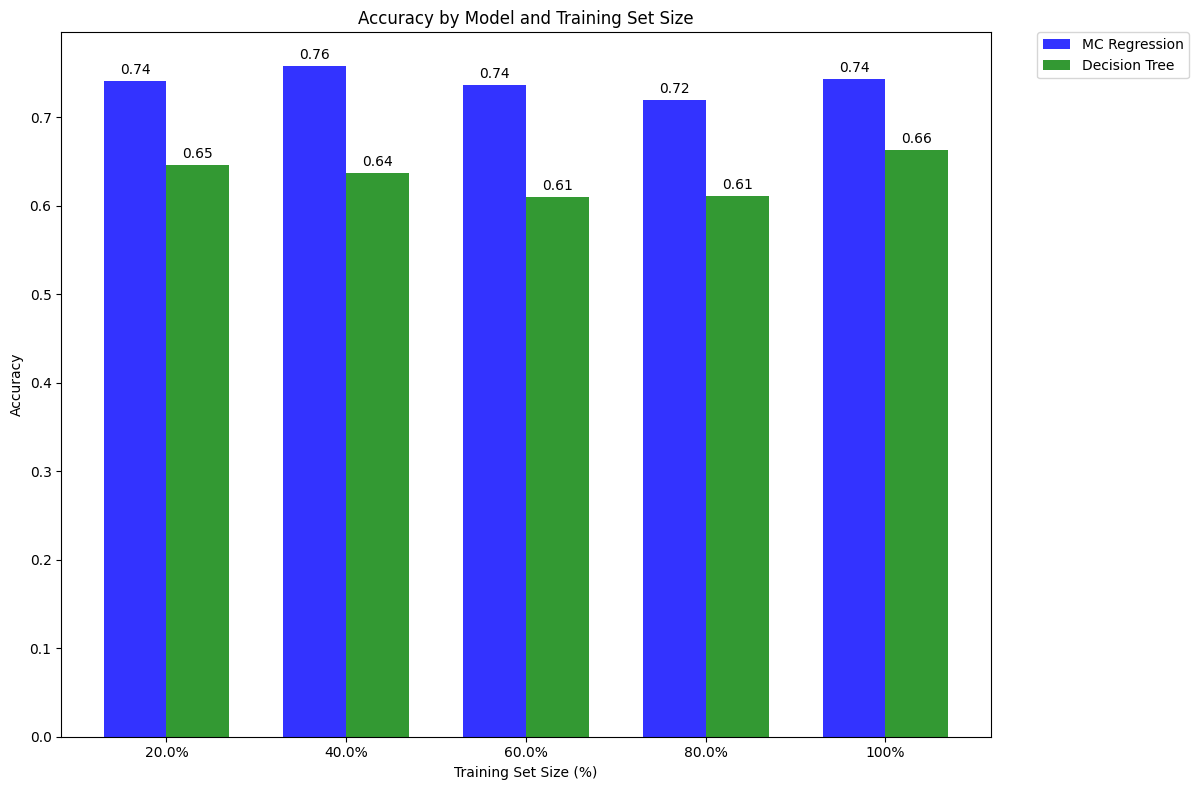

In [11]:
def experiment_four(X_train_news, y_train_news, X_test_news, y_test_news):
    """
    Plot and compare the accuracy of DT and Multiclass Regression as a function of the
    size of the dataset by controlling the training size.
    
    Randomly select 20%, 40%, 60%, and 80% of the available 
    training data and train your model on this subset and evaluate the trained 
    model on the held-out test set.
    """
    results = {}
    for i in range(20, 101, 20):
        train_size = i/100
        if i < 100:
            _, X_train_subset, _, y_train_subset = train_test_split(X_train_news, y_train_news, train_size=train_size, stratify=y_train_news)
        else:  
            X_train_subset = X_train_news
            y_train_subset = y_train_news
            train_size = 1
        
        multiclass_accuracy, y_pred = evaluate_multiclass_classification(X_train_subset, y_train_subset, X_test_news, y_test_news, n_classes=5)
        
        dt_model = DecisionTreeClassifier()
        dt_model.fit(X_train_subset, y_train_subset)
        y_pred_dt = dt_model.predict(X_test_news)
        accuracy_dt = accuracy_score(y_test_news, y_pred_dt)
        
        results[f'{train_size*100}%'] = (multiclass_accuracy, accuracy_dt)
        
    plot_news_data_on_multiple_training_sizes(results)
    
experiment_four(X_train_news, y_train_news, X_test_news, y_test_news)

### Experiment 5 ###

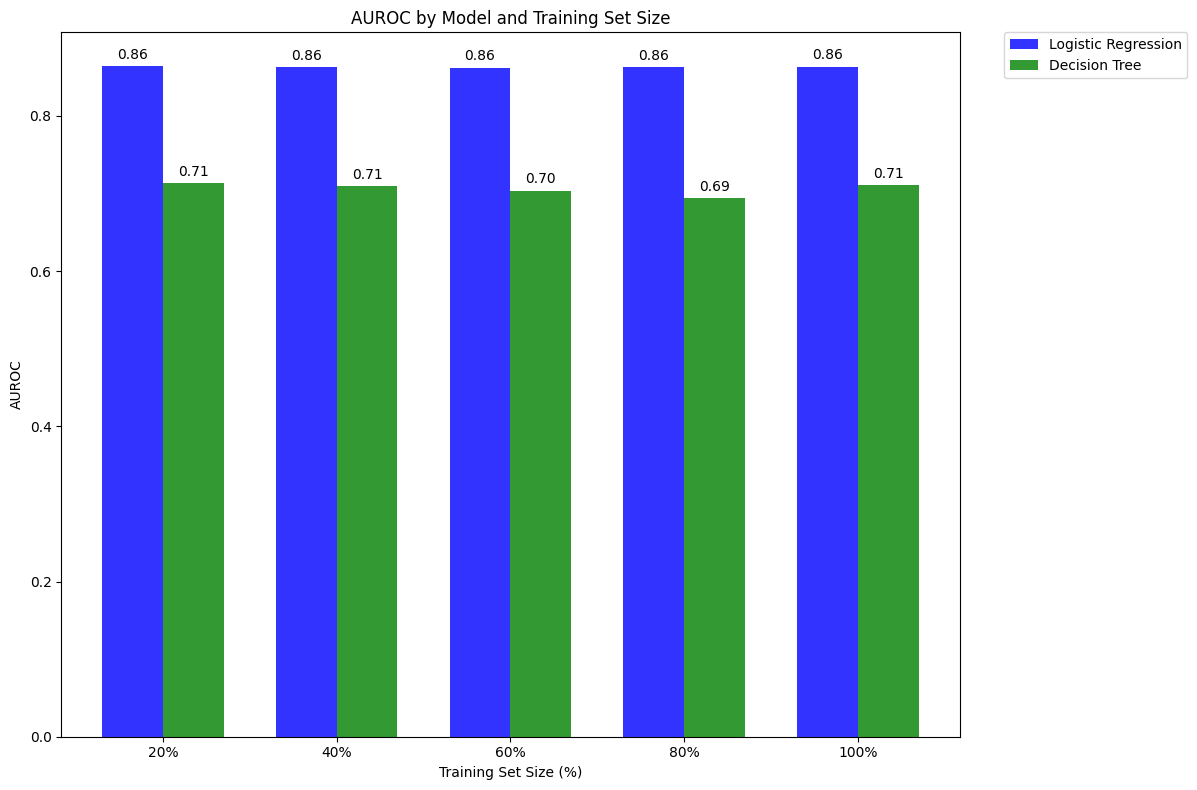

In [12]:
def experiment_five(X_train, y_train, X_test, y_test, top_indices):
    """
    Plot and compare the AUROC of DT and LogisticRegression as a function of the
    size of the dataset by controlling the training size.
    
    Randomly select 20%, 40%, 60%, and 80% of the available 
    training data and train your model on this subset and evaluate the trained 
    model on the held-out test set.
    """
    log_model = CustomLogisticRegression(learning_rate=0.01, epsilon=1e-5, max_iters=1e2)
    dt_model = DecisionTreeClassifier()
    results = {}  # Ex: '20%': (auroc_log, auroc_dt)
    
    for i in range(20, 101, 20):
        if i < 100:
            _, X_train_sub, _, y_train_sub = train_test_split(X_train, y_train, train_size=i/100, stratify=y_train)
        else:
            X_train_sub = X_train
            y_train_sub = y_train
        
        log_model.fit(X_train_sub, y_train_sub)
        dt_model.fit(X_train_sub, y_train_sub)
    
        y_pred_prob_test_log = log_model.predict(X_test)
        y_pred_prob_test_dt = dt_model.predict_proba(X_test)[:, 1]
        
        auroc_log = auc(*roc_curve(y_test, y_pred_prob_test_log)[:2])
        auroc_dt = auc(*roc_curve(y_test, y_pred_prob_test_dt)[:2])
        
        results[f'{i}%'] = (auroc_log, auroc_dt)
    
    # Plotting the results
    plot_imdb_data_auroc(results)
    
experiment_five(X_train_filtered, y_train_binary, X_test_filtered, y_test_binary, top_indices)
    

### Experiment 6 ###

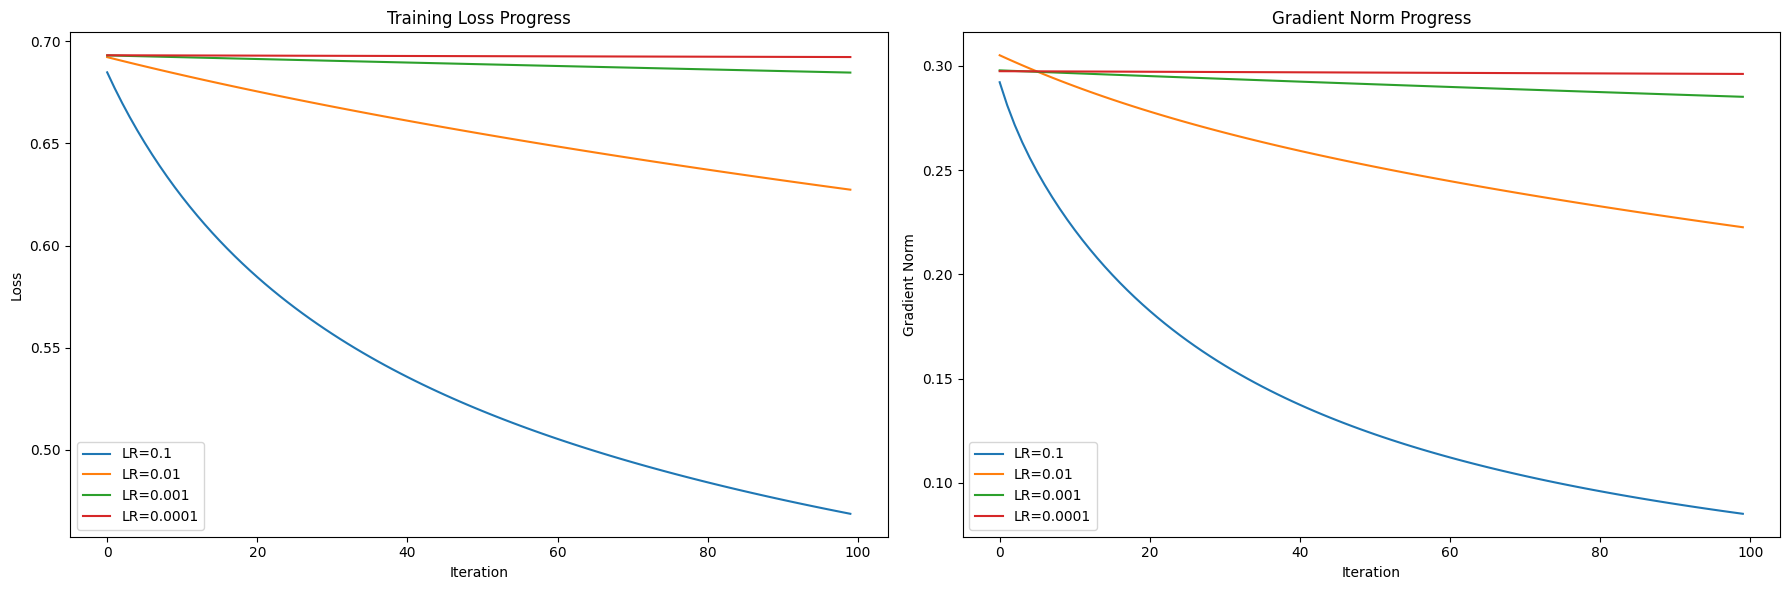

In [13]:
def experiment_six(X_train, y_train, X_test, y_test):
    """
    Compare and evaluate the performance of different learning rates
    """
    histories = {}
    results = {}
    for i in range(1,5):
        lr = 10**-i
        model = CustomLogisticRegression(learning_rate=lr, epsilon=1e-5, max_iters=1e2, record_training=True)
        model.fit(X_train, y_train)
        y_pred_prob = model.predict(X_test)
        
        histories[str(lr)] = (model.loss_history, model.gradient_norm_history)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc_train = auc(fpr, tpr)
        results[str(lr)] = (fpr, tpr, roc_auc_train)
        
    plot_model_convergence(histories, results)
        
experiment_six(X_train_filtered, y_train_binary, X_test_filtered, y_test_binary)

### Experiment 7 ###

Iter 220, Loss: 0.4483, Val Loss: 0.8661:   5%|▍         | 226/5000 [00:01<00:38, 123.76it/s]


Stopping early at iteration 226, min validation loss: 0.8512
Best weights found at iteration 126
validation loss did not improve for 100 iterations


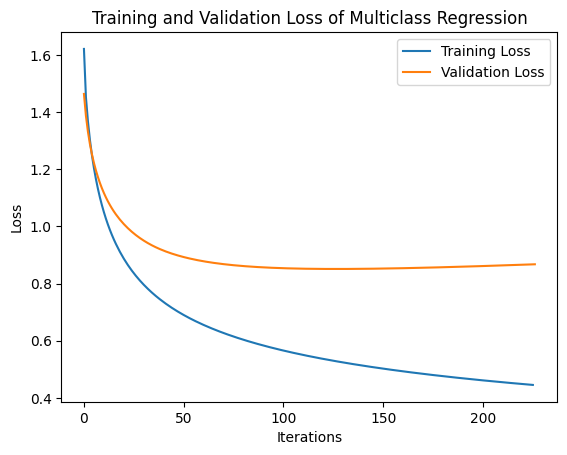

Test Accuracy: 0.8171487603305785


Iter 290, Loss: 0.2213, Val Loss: 0.3860: 100%|██████████| 300/300 [00:01<00:00, 252.19it/s]


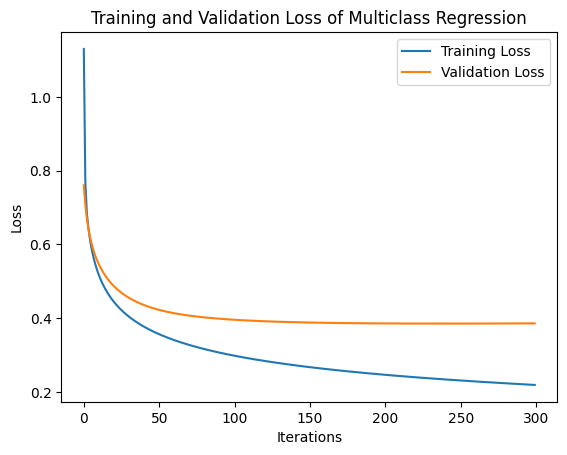

Test Accuracy for k=3: 0.8121597096188747


Iter 290, Loss: 0.5859, Val Loss: 1.0376: 100%|██████████| 300/300 [00:04<00:00, 69.33it/s]


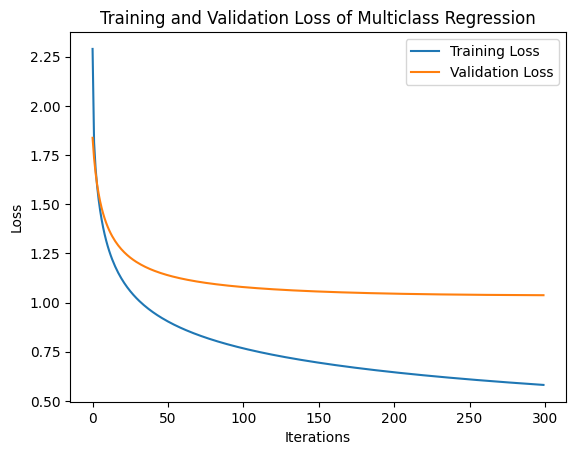

Test Accuracy for k=8: 0.6735294117647059


Iter 290, Loss: 0.8641, Val Loss: 1.5442: 100%|██████████| 300/300 [00:21<00:00, 14.25it/s]


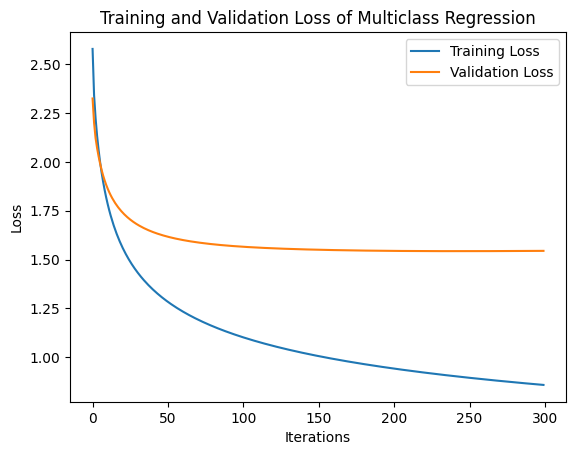

Test Accuracy for k=13: 0.6400951814396193


Iter 290, Loss: 1.0556, Val Loss: 1.2600: 100%|██████████| 300/300 [00:16<00:00, 17.99it/s]


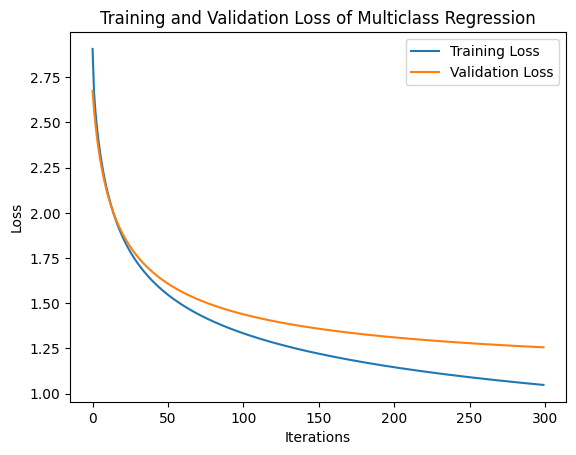

Test Accuracy for k=18: 0.5990532204848659


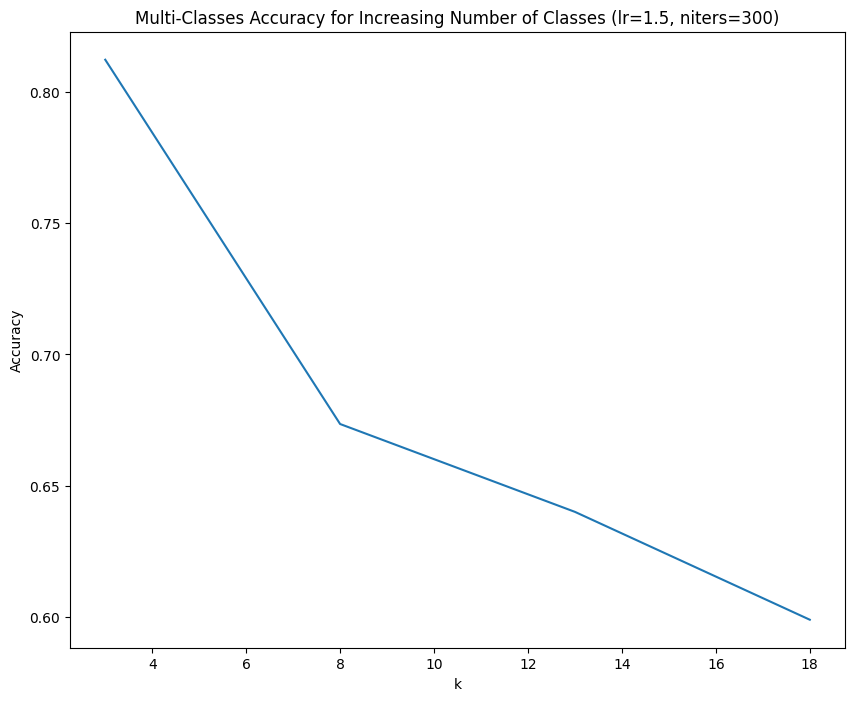

In [14]:
def experiment_eight():
    """
    Plot the loss of the multiclass regression over iterations
    """
    def get_20_newsgroups_data(categories=None):
        train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
        test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
        return train, test

    def vectorize_data(train, test):
        # convert the text to word count vectors
        count_vect = CountVectorizer(stop_words='english', max_df=0.5, min_df=2)
        X_train = count_vect.fit_transform(train.data)
        X_test = count_vect.transform(test.data)
        Y_train = train.target
        Y_test = test.target
        feature_map = count_vect.vocabulary_
        return X_train, X_test, Y_train, Y_test, feature_map

    def reduce_dimensions(X_train, Y_train, X_test, D=1000):
        # Feature selection using Mutual Information
        feature_selection = SelectKBest(mutual_info_classif, k=D)
        X_train_selected = feature_selection.fit_transform(X_train, Y_train)
        X_test_selected = feature_selection.transform(X_test)
        return X_train_selected, X_test_selected

    def plot_loss(loss_history, validation_loss, params=None):
        plt.plot(loss_history, label='Training Loss')
        plt.plot(validation_loss, label='Validation Loss')
        # title
        plt.title('Training and Validation Loss of Multiclass Regression')
        # if params, expand the params , k=v for k, v in params.items()
        if params:
            plt.text(0, 0, '\n'.join([f'{k}={v}' for k, v in params.items()]))
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('multiclass_loss.png')
        plt.show()

    def fit_multiclass(X_train, Y_train, learning_rate=0.05, niters=2000):
        # evaluates a MultiClassRegression model 
        # the model is fit to the training data and then evaluated on the test data
        n = X_train.shape[1]
        C = len(np.unique(Y_train))
        mc_model = MultiClassRegression(nFeatures=n, nClasses=C)
        validation_split = 0.05
        mc_model, loss_history, validation_loss = mc_model.fit(X_train.toarray(), Y_train, lr=learning_rate, niters=niters, validation_split=validation_split)
        params = {
            'learning_rate': learning_rate,
            'niters': niters,
            'validation_split': validation_split
        }
        plot_loss(loss_history, validation_loss)
        return mc_model

    def evaluate_multiclass(X_test, Y_test, mc_model):
        # evaluate the model on the test data
        y_pred = mc_model.predict(X_test.toarray())
        accuracy = accuracy_score(Y_test, y_pred)
        return accuracy

    def get_newsgroup_split(categories=None):
        #Load the dataset
        # categories = None
        train, test = get_20_newsgroups_data(categories)
        X_train, X_test, Y_train, Y_test, feature_map = vectorize_data(train, test)
        X_train_selected, X_test_selected = reduce_dimensions(X_train, Y_train, X_test, D=1000)
        return X_train_selected, X_test_selected, Y_train, Y_test

    def evaluate_multiclass_classification(X_train_selected, X_test_selected, Y_train, Y_test):
        """
        Compute classification accuracy.
        """
        mc_model = fit_multiclass(X_train_selected, Y_train, learning_rate=0.5, niters=5000)
        accuracy = evaluate_multiclass(X_test_selected, Y_test, mc_model)
        print(f"Test Accuracy: {accuracy}")
        
    # load data
    categories = ['comp.graphics', 'misc.forsale', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']
    X_train_selected, X_test_selected, Y_train, Y_test = get_newsgroup_split(categories)
    
    # evaluate the model
    evaluate_multiclass_classification(X_train_selected, X_test_selected, Y_train, Y_test)
    
    def experiment_seven():
        """
        Evaluate the performance of the multiclass regression on more than 5 classes
        
        Compare the top k (e.g. k =3) predicted classes. 
        A correct prediction is determined by whether the true label is within the top k predicted labels. 
        The scoring mechanism involves assigning a score of 1 if the correct label is among the top k predictions and 0 otherwise.
        """

        categories = ['alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc']

        results = {}

        for k in range(3, len(categories), 5):
            current_categories = categories[:k]
            X_train_selected, X_test_selected, Y_train, Y_test = get_newsgroup_split(current_categories)
            mc_model = fit_multiclass(X_train_selected, Y_train, learning_rate=1.5, niters=300)
            y_pred = mc_model.predict(X_test_selected.toarray())
            accuracy = accuracy_score(Y_test, y_pred)
            print(f"Test Accuracy for k={k}: {accuracy}")
            results[k] = accuracy

        return results

    exp7_results = experiment_seven()
    def plot_experiment_seven(results):
        """
        Plot the results of experiment seven
        """
        # line plot
        plt.figure(figsize=(10, 8))
        plt.plot(results.keys(), results.values(), label='Accuracy')
        plt.title( 'Multi-Classes Accuracy for Increasing Number of Classes (lr=1.5, niters=300)')
        plt.xlabel('k')
        plt.ylabel('Accuracy')
        plt.savefig('experiment_7_results.png')
        plt.show()

    plot_experiment_seven(exp7_results)
    
experiment_eight()

Iter 1990, Loss: 1.4903, Val Loss: 1.4957: 100%|██████████| 2000/2000 [00:09<00:00, 221.91it/s]


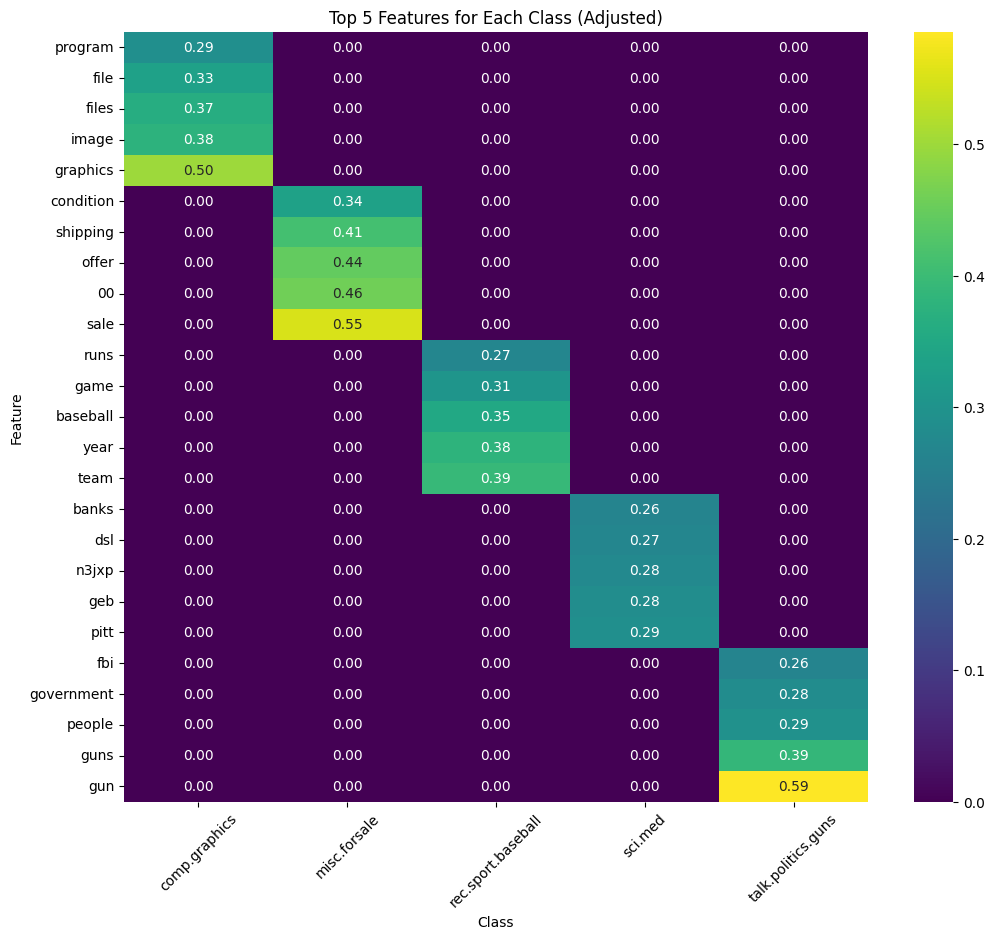

In [15]:
def experiment_nine(X_train, y_train, X_test, y_test, selected_feature_names, n_classes=5, n_features=500):
    """
    Create a heatmap showing the top 5 most positive features as rows
    for each class as columns in the multi-class classification
    """
    #Train the MultiClassRegression model
    n_features = X_train.shape[1]
    mc_model = MultiClassRegression(nFeatures=n_features, nClasses=n_classes)
    mc_model.fit(X_train.toarray(), y_train, lr=0.05, niters=2000, validation_split=0.2)

    #Evaluate model
    y_pred = mc_model.predict(X_test.toarray())
    accuracy = accuracy_score(y_test, y_pred)
    class_label_dict = {1: 'comp.graphics', 2: 'misc.forsale', 3: 'rec.sport.baseball', 4: 'sci.med', 5: 'talk.politics.guns'}

    plot_heatmap_of_multi_classification(mc_model.W, selected_feature_names, class_label_dict, n_top_features=5)
    
experiment_nine(X_train_news, y_train_news, X_test_news, y_test_news, selected_feature_names, n_classes=5, n_features=500)